In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# CO₂ Leakage Probability — Weighting, Confidence Evaluation, and Efficiency Analysis

### Purpose
This notebook reproduces the **second part** of the workflow described in the paper *“Quantifying CO₂ Leakage risk when Planning Safe Geological Carbon Storage using importance sampling of failure probabilities”*.  

It continues from the previous notebook (`Script_after_prior_simulation_2025.ipynb`), which generated and reconstructed the Importance Sampling (IS) realizations (**m′⁽ˡ⁾**).  
Here, we use the **outputs of the CO₂ flow simulations (MRST)** for both the **IS** and **full Naïve Monte Carlo (NMC)** ensembles to compute importance weights, effective sample sizes (ESS), and final leakage-probability estimates with confidence bounds.

---

### Pipeline Overview
This notebook covers these steps:

| Step | Description                                                                                                                               | Status            |
| ---- | ----------------------------------------------------------------------------------------------------------------------------------------- | ----------------- |
| 1    | Load model inputs sampled by Naïve Monte Carlo (**m₁: top surfaces**, **m₂: porosity**)                                                   | ⏪ previous notebook                 |
| 2    | Load failure/no failure outcomes **h₁⁽ˡ⁾** obtained from forward simulations            | ⏪ previous notebook   |
| 3    | Estimate running failure probability and Compute Chebyshev confidence bands                                                                | ⏪ previous notebook |
| 4    | Estimate Required Number of Simulations Using Chebyshev’s Inequality and check if desired confidence interval relative to the prescribed safety threshold **p_risk** has been reached with the initial set of **L** simulations| ⏪ previous notebook  |
| 5    | Check if Importance Sampling (IS) is necessary                                                                                            | ⏪ previous notebook |
| 5.1  | Apply PCA on **m₁** and **m₂** to reduce dimensionality                                                                                   | ⏪ previous notebook |
| 5.2  | Perform DGSA on PCA scores to identify sensitive components                                                                               | ⏪ previous notebook  |
| 5.3  | Fit MKDE (Multivariate Kernel Density Estimation) on sensitive PC scores to construct the IS alternative distribution **g(m)**            | ⏪ previous notebook |
| 5.4  | Resample new PC scores from IS alternative distribution **g(m)**                                                                          | ⏪ previous notebook |
| 5.5  | Reconstruct model variables (**m₁′**, **m₂′**) with the resampled PC scores                                                               | ⏪ previous notebook  |
| 6    | Compute IS weights                                                                                        | ✅ |
| 7    | Estimate IS running leakage probability and Chebyshev band using ESS                                                                      | ✅ |
| 8    | Check if desired confidence interval relative to the prescribed safety threshold **p_risk** has been reached    | ✅ |


---

### Output Summary
This notebook produces weighted leakage-probability estimates ($\hat{p}_{IS}$), effective sample sizes (ESS), and confidence intervals based on Chebyshev bounds.  
It also compares the IS and NMC ensembles in terms of **accuracy**, **variance reduction**, and **computational efficiency** — completing the full importance-sampling workflow.


**Loaded components**

- **Input folder**  
  Case-specific output directory: `Inputs_for_Final_Script_after_IS_Simulation`.

- **Multivariate Kernel Density Estimators (MKDE)**  
  - `f_m` — Target distribution $f(\mathbf{m})$ (non-conditioned; fit on the full ensemble).  
  - `g_m` — Proposal distribution $g(\mathbf{m})$ (conditioned toward leakage events).

- **Resampled scores**  
  - `RS_failure_sensitive_scores` — Principal-component scores resampled from $g(\mathbf{m})$ for reconstructing new model variables and realizations.

- **Leakage indicators (from MRST simulations)**  
  - `h_1`, `h_1_IS`, `h_1_full_NMC` — Binary arrays marking leakage ($1 = \text{leakage}$) for NMC, IS, and full-NMC ensembles.

- **Failure counts (from MRST simulations)**  
  - `sum_hi_failures_full_NMC`, `sum_hi_failures_IS` — Aggregated number of leakage events in the full-NMC and IS ensembles, respectively.

**Why these matter**  
Together, these datasets enable computation of **importance weights**, **weighted leakage probabilities**, and direct comparison of **variance-reduction efficiency** between IS and NMC approaches.  

The inclusion of the **full_NMC** ensemble $h_{1,\text{full\_NMC}}$ provides a *reference baseline* representing the complete set of Monte Carlo simulations (thousands of realizations). The **first 300 realizations** of this full set correspond to the same subset used in the first (L=300) ensemble of Naïve Monte Carlo (NMC). This allows direct evaluation of how well the smaller IS ensemble reproduces the leakage statistics and confidence bounds of the much larger full Monte Carlo experiment.


In [ ]:
# Define input folder path
case_name_input = 'Inputs_for_Final_Script_after_IS_Simulation'
INPUTS_FOLDER = '/Users/sofiamantillasalas/Library/CloudStorage/GoogleDrive-sofiams@stanford.edu/My Drive/Research_Python/Structural_trapping/Jupyter_Python_Research/Outputs_jupyter/' + case_name_input + '/'

#load all necessary data from previous steps
# MKDE models f_m and g_m pickled
with open(INPUTS_FOLDER + 'f_m_' + case_name_input + '.pkl', 'rb') as file:
    f_m = pickle.load(file)
with open(INPUTS_FOLDER + 'g_m_' + case_name_input + '.pkl', 'rb') as file:
    g_m = pickle.load(file)
# RS failure sensitive scores 
RS_failure_sensitive_scores = np.load(INPUTS_FOLDER + 'RS_failure_sensitive_scores.npy') 
# h_1 models leaking in Naive Monte Carlo (NMC), Importance Sampling (IS), and full NMC
h_1 = np.load(INPUTS_FOLDER + 'h_1_models_leaking.npy')
h_1_IS = np.load(INPUTS_FOLDER + 'h_1_models_leaking_IS.npy')
h_1_full_NMC = np.load(INPUTS_FOLDER + 'h_1_models_leaking_full_NMC.npy')
# sum of h_i failures in IS and full N
sum_hi_failures_full_NMC = np.load(INPUTS_FOLDER + 'sum_hi_failures_full_NMC.npy')
sum_hi_failures_IS = np.load(INPUTS_FOLDER + 'sum_hi_failures_IS.npy') 

In [ ]:
# Compute Importance Sampling weights
# Evaluate PDFs at RS failure sensitive scores
f_m_pdf = f_m.pdf()  # non-conditioned
g_m_pdf  = g_m.pdf()   # conditioned (leakage)

f_m_pdf_RS = f_m_pdf[RS_failure_sensitive_scores.astype(int)]  # f(m)
g_m_pdf_RS  = g_m_pdf[RS_failure_sensitive_scores.astype(int)]   # g(m)
weights_RS   = f_m_pdf_RS / g_m_pdf_RS

average_weights = np.mean(weights_RS, axis=1)

weighted_h_1_IS = h_1_IS * average_weights
weightmean    = np.mean(weighted_h_1_IS) * 100
weightmean_op = 100 - weightmean

a = np.sum(sum_hi_failures_IS)
b = len(h_1_IS)
print('Unweighted resampled leak samples:', a)
print(f'Unweighted resampled leak rate: {a/b*100:.2f}%')

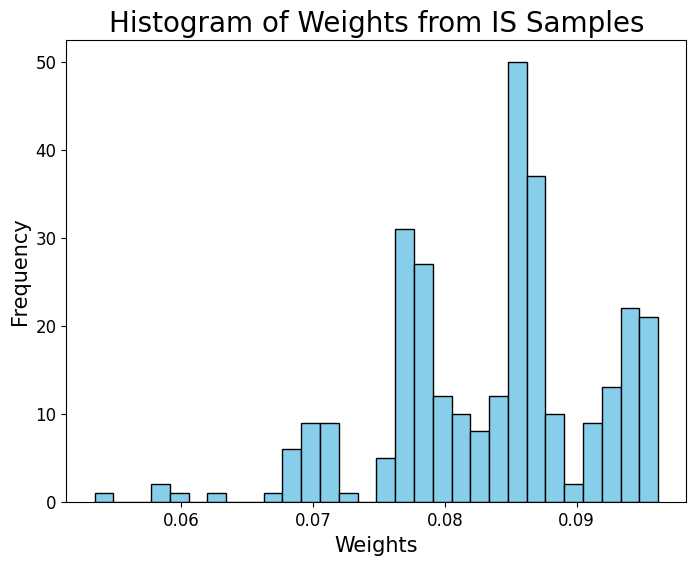

In [64]:
#plot weights histogram
plt.figure(figsize=(8, 6))
plt.hist(average_weights, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Weights', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Histogram of Weights from IS Samples', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### Visualize the Impact of Weighting on Leakage Proportions

To illustrate how **importance weighting** reshapes the effective leakage proportions, we compare the **unweighted** and **weighted** outcomes of the Importance Sampling (IS) ensemble.

Each pie chart displays the share of IS realizations that resulted in leakage above or below the defined safety threshold (≥ 0.1% of total injected CO₂).  
- The **unweighted pie** represents the *raw frequency* of leakage-prone models directly from the resampled ensemble.  
- The **weighted pie** shows the *probability-adjusted contribution* of each realization after applying the IS weights $w_i = f(\mathbf{m}_i)/g(\mathbf{m}_i)$.

Applying the weights corrects for the bias introduced by sampling from the failure-prone proposal distribution $g(\mathbf{m})$.  
Leakage-prone samples, which were deliberately oversampled to ensure rare events are well represented, are **down-weighted**, restoring the unbiased expectation with respect to the target distribution $f(\mathbf{m})$.

Together, these figures show the transition from an overrepresented leakage rate (≈ 31.7%) to the corrected weighted rate (≈ 2.6%).


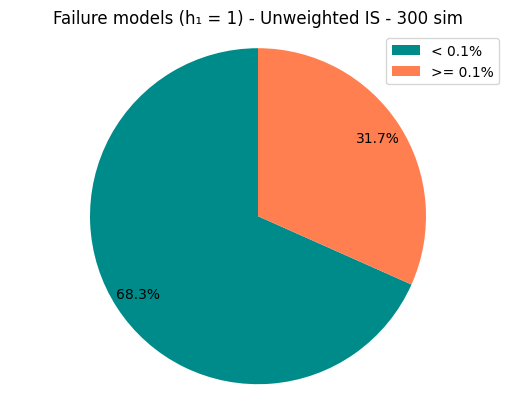

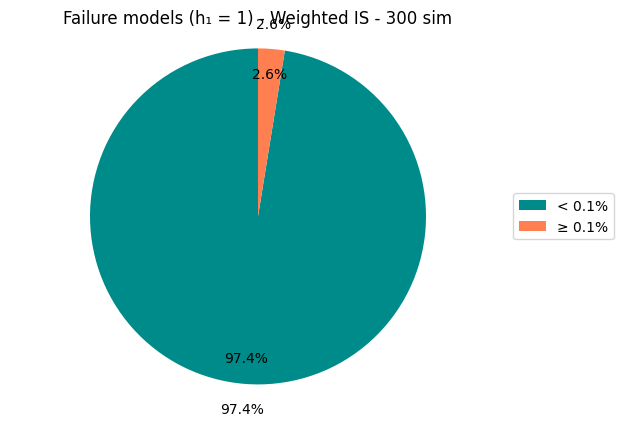

In [ ]:
leakage_percentage = ["< 0.1%", ">= 0.1%"]
model_count = [b - a, a]

fig, ax = plt.subplots()
wedges, labels, _ = ax.pie(model_count, startangle=90, autopct='%1.1f%%',
                           pctdistance=0.85, colors=['darkcyan', 'coral'])
ax.axis('equal')
ax.set_title('Failure models (h₁ = 1) - Unweighted IS - {} sim'.format(b))
for label, wedge in zip(labels, wedges):
    angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
    x, y  = np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))
    ax.text(x * 1.15, y * 1.15, label.get_text(), ha='center', va='center')
ax.legend(wedges, leakage_percentage)
plt.show()

leakage_labels = ["< 0.1%", "≥ 0.1%"]
model_count    = [weightmean_op, weightmean]

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(model_count, startangle=90, autopct='%1.1f%%',
                                  pctdistance=0.85, colors=['darkcyan', 'coral'])
ax.axis('equal')
ax.set_title('Failure models (h₁ = 1) - Weighted IS - {} sim'.format(b))
for txt, wedge in zip(autotexts, wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x, y  = np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))
    ax.text(x * 1.15, y * 1.15, txt.get_text(), ha='center', va='center')
ax.legend(wedges, leakage_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### **Step 7 — Estimate IS Running Leakage Probability and Chebyshev Band Using ESS**

This step evaluates how **importance sampling (IS)** improves the estimation of leakage probability compared to the Naïve Monte Carlo (NMC) baseline by tracking running means, variances, and confidence bounds.

- The **weighted leakage indicator** is $h_1^{IS,w} = h_1^{IS}\, w_i$, where $w_i = f(\mathbf{m}_i)/g(\mathbf{m}_i)$.  
- The **Effective Sample Size (ESS)** quantifies the equivalent number of independent samples in the weighted IS ensemble:

  $$
  ESS = \frac{(\sum_i w_i)^2}{\sum_i w_i^2}
  $$

- **Chebyshev’s inequality** provides confidence bands around the running mean to assess when the leakage probability estimate stabilizes:

  $$
  P(|\hat{p}_n - p| \geq \epsilon\,p) \leq \frac{1}{k^2}, \quad k = \frac{1}{\sqrt{\delta}}
  $$

**Outputs:**
- `mu_IS_weighted` and `mu_naiveMC` — Mean leakage probabilities for IS and NMC.  
- `ess_array` — Running ESS.  
- `ub_post`, `ub_full` — Chebyshev upper bounds.  
- `n_cross_post`, `n_cross_full` — Sample counts where bounds meet the safety criterion.

In [ ]:
# NaiveMC baseline, diagnostics, Chebyshev
w_leak = average_weights * h_1_IS
var_IS_leak = np.var(w_leak)
print(f'var_IS_leak = {var_IS_leak}')
mu_IS_weighted = np.mean(weighted_h_1_IS)
print(f'mu_IS_weighted = {mu_IS_weighted}')
mu_naiveMC = np.mean(h_1)
print(f'mu_naiveMC = {mu_naiveMC}')
epsilon = 0.33
print(f'epsilon = {epsilon}')
delta_tolerance = 0.05
n_naive = (mu_naiveMC*(1 - mu_naiveMC))/ (delta_tolerance * (epsilon**2) * (mu_naiveMC**2))
print(f'n_naive = {n_naive}')
# Full NaiveMC sample diagnostics
print(f'sum_hi_failures_full_NMC = {sum_hi_failures_full_NMC} models with leakage out of {len(h_1_full_NMC)} samples in full Naive MC')

var_IS_leak = 0.0014339576685375199
mu_IS_weighted = 0.025546576979513038
mu_naiveMC = 0.03
epsilon = 0.33
n_naive = 5938.169574533209


In [62]:
# 9) Running stats & plot
# ===========================

def running_stats(x):
    n = len(x)
    idx  = np.arange(1, n+1)
    c1   = np.cumsum(x)
    c2   = np.cumsum(x**2)
    mean = c1/idx
    var  = (c2 - idx*mean**2)/np.maximum(idx-1, 1)
    var[0] = 0.0
    return mean, var

# (a) first-300 MC only
mean_NMC, var_NMC = running_stats(h_1)
std_NMC   = np.sqrt(var_NMC)
i_NMC     = np.arange(1, len(mean_NMC)+1)
se_NMC    = std_NMC / np.sqrt(i_NMC)

# (b) IS batch
mean_IS, var_IS = running_stats(weighted_h_1_IS)
std_IS   = np.sqrt(var_IS)

# dynamic ESS for IS
weights   = average_weights
cw, cw2   = np.cumsum(weights), np.cumsum(weights**2)
ess_array = cw**2 / cw2 # effective sample size at each step

L_IS   = len(weighted_h_1_IS)
L_NMC = len(h_1)  
i_IS = np.arange(1, len(mean_IS)+1) + L_NMC

eff_IS          = np.empty_like(i_IS, dtype=float)
eff_IS[:L_IS]   = np.arange(1, L_IS+1)
eff_IS[L_IS:]   = L_IS + ess_array[: len(i_IS) - L_IS]
se_IS = std_IS / np.sqrt(eff_IS) 

# (c) full MC chain
mean_full, var_full = running_stats(h_1_full_NMC)
std_full  = np.sqrt(var_full)
i_full    = np.arange(1, len(mean_full)+1)
se_full   = std_full / np.sqrt(i_full)

# Chebyshev & crossings (unchanged)
epsilon, delta = 0.4, 0.05
k_cheb = 1/np.sqrt(delta)
p_hat  = mean_full[-1]
upper_tgt = (1 + epsilon) * p_hat
lower_tgt = (1 - epsilon) * p_hat
safety    = 0.04   # as in your code

ub_full = mean_full + k_cheb * se_full
ub_post = mean_IS + k_cheb * se_IS

mask_full = np.where(i_full >= 310)[0]
mask_post = np.where(i_IS >= 310)[0]
cross_full = mask_full[np.where(ub_full[mask_full] <= safety)[0]]
cross_post = mask_post[np.where(ub_post[mask_post] <= safety)[0]]
n_cross_full = int(i_full[cross_full[0]]) if cross_full.size else None
n_cross_post = int(i_IS[cross_post[0]]) if cross_post.size else None


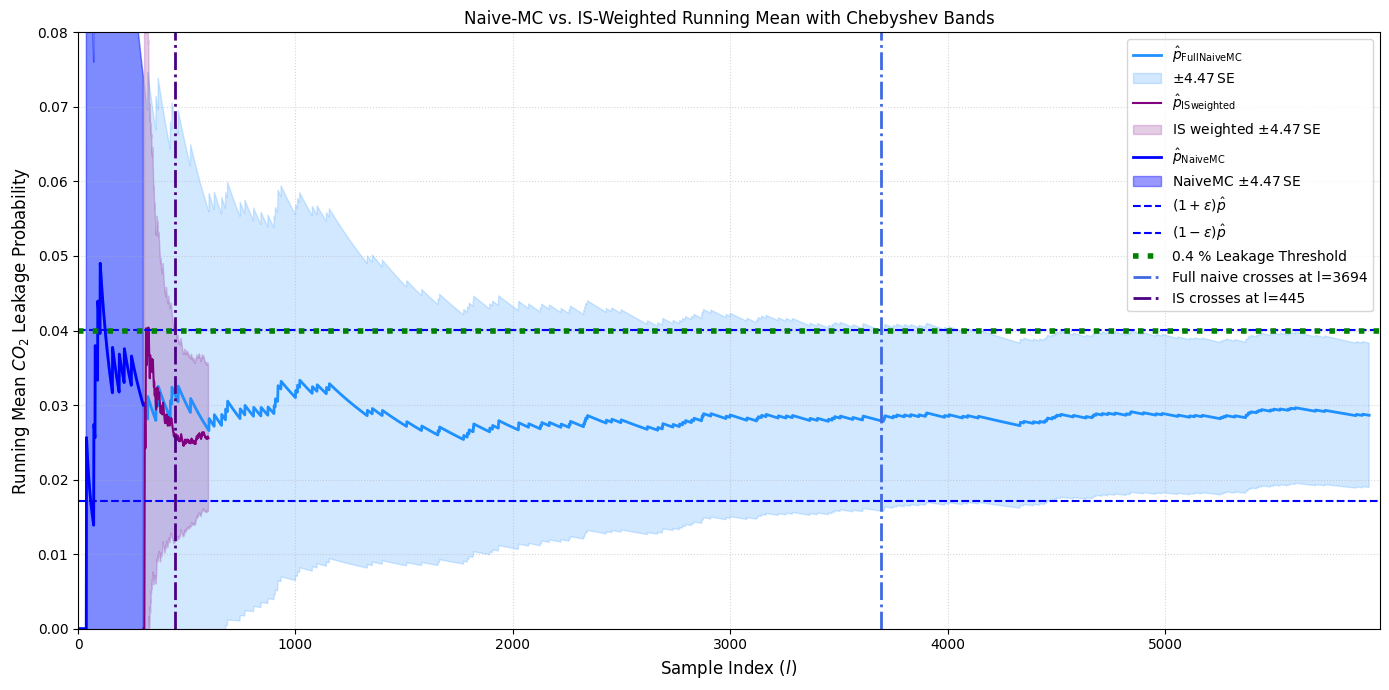

In [ ]:

# Plot (unchanged visuals)
plt.figure(figsize=(14, 7))
plt.plot(i_full, mean_full, color='dodgerblue', lw=2, label=r'$\hat{p}_{\mathrm{Full NaiveMC}}$')
plt.fill_between(i_full, mean_full - k_cheb*se_full, mean_full + k_cheb*se_full,
                 color='dodgerblue', alpha=0.2, label=rf'$\pm {k_cheb:.2f}\,\mathrm{{SE}}$')

plt.plot(i_IS, mean_IS, color='purple', label=r'$\hat{p}_{\mathrm{ISweighted}}$')
plt.fill_between(i_IS, mean_IS - k_cheb*se_IS, mean_IS + k_cheb*se_IS,
                 color='purple', alpha=0.2, label=rf'IS weighted $\pm {k_cheb:.2f}\,\mathrm{{SE}}$')

plt.plot(i_NMC, mean_NMC, color='blue', lw=2, label=r'$\hat{p}_{\mathrm{NaiveMC}}$')
plt.fill_between(i_NMC, mean_NMC - k_cheb*se_NMC, mean_NMC + k_cheb*se_NMC,
                 color='blue', alpha=0.4, label=rf'NaiveMC $\pm {k_cheb:.2f}\,\mathrm{{SE}}$')

plt.axhline(upper_tgt, color='blue', ls='--', lw=1.5, label=r'$(1+\varepsilon)\hat{p}$')
plt.axhline(lower_tgt, color='blue', ls='--', lw=1.5, label=r'$(1-\varepsilon)\hat{p}$')
plt.axhline(safety,    color='green', ls=':', lw=4, label='0.4 % Leakage Threshold')

if n_cross_full:
    plt.axvline(n_cross_full, color='royalblue', ls='-.', lw=2, label=f'Full naive crosses at l={n_cross_full}')
if n_cross_post:
    plt.axvline(n_cross_post, color='indigo', ls='-.', lw=2, label=f'IS crosses at l={n_cross_post}')

plt.xlim(0, max(i_full.max(), i_IS.max()) + 50)
plt.ylim(0, 0.08)
plt.xlabel('Sample Index ($l$)', fontsize=12)
plt.ylabel('Running Mean $CO_2$ Leakage Probability', fontsize=12)
plt.title('Naive-MC vs. IS-Weighted Running Mean with Chebyshev Bands')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()


### **Step 8 — Check if Desired Confidence Interval Relative to the Safety Threshold $p_{\text{risk}}$ Has Been Reached**

This step verifies whether the **importance-sampling (IS)** ensemble achieves the prescribed safety confidence level faster than the full Naïve Monte Carlo (NMC) baseline.

Using the **Chebyshev confidence bands**, we compare how quickly the running mean of the IS-weighted leakage probability $\hat{p}_{IS}$ converges relative to the leakage threshold $p_{\text{risk}} = 0.004$ (0.4%).  

**Interpretation:**
- The **blue line** shows the running leakage probability from NMC with its $\pm k\,\text{SE}$ confidence band (light blue).  
- The **purple line** shows the IS-weighted running mean and corresponding Chebyshev band.  
- The **green dashed line** marks the safety threshold $p_{\text{risk}}$.  
- Vertical lines indicate the number of realizations required for each method to meet the safety tolerance:
  - **NMC:** crosses at $L = 3694$ realizations.  
  - **IS:** crosses at $L = 445$ realizations.  

**Takeaway:**  
The IS ensemble reproduces the same statistical confidence in leakage risk using **≈8× fewer simulations**, confirming substantial variance reduction and computational savings relative to the full NMC approach.
